# Test rsfc matrix extraction

Use the default harvard oxford atlas and the power spheres we've defined to ensure fc matrices look about right

In [27]:
import os
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
%matplotlib inline

data_dir = '/home/jflournoy/data/GenR_motion/'
sub_dir = '/sub-1045/ses-F09/func/'
rs_file = 'sub-1045_ses-F09_task-rest_acq-0006_run-0000_space-MNI152NLin2009cAsym_desc-nuisanced_bold.nii.gz'
rsfilename = data_dir + '/' + sub_dir + '/' + rs_file
rsfilename

#grab the harvard oxford labels 
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

#create a masker that will allow us to extract signal from rois defined here
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)
#initiallize a clean variable to hold the extracted timeseries
time_series = None
if os.path.isfile(rsfilename):
    anImg = nib.load(rsfilename)
    time_series = masker.fit_transform(anImg)

[NiftiLabelsMasker.fit_transform] loading data from /home/jflournoy/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
[Memory]0.4s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


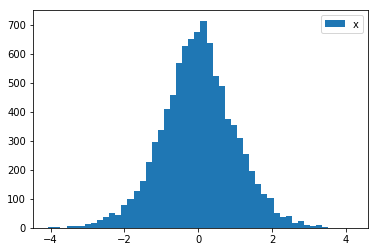

In [14]:
#plot a histogram to check
plt.pyplot.hist(time_series.flatten(), bins=50, alpha=1, label='x')
plt.pyplot.legend(loc='upper right')
plt.pyplot.show()

In [22]:
#compute the connectivity matrix
#This uses a slightly regularized correlation estimator
#https://neurostars.org/t/connectivitymeasure-function-in-nilearn-compare-with-corrcoef-in-matlab/3659/2
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, None)

#again, check the hist


/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


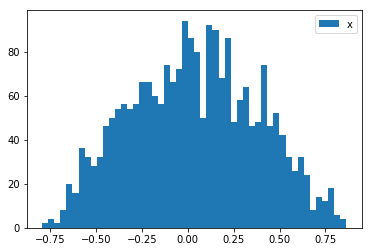

In [23]:
plt.pyplot.hist(correlation_matrix.flatten(), bins=50, alpha=1, label='x')
plt.pyplot.legend(loc='upper right')
plt.pyplot.show()


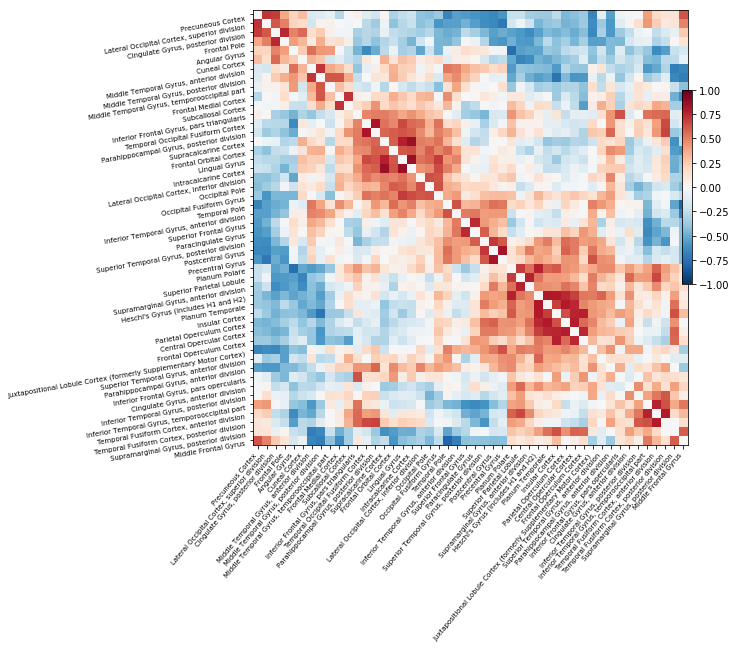

In [25]:
# Plot the correlation matrix
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=1, vmin=-1, reorder=True)

# Repeat, but with the parcellation scheme we're using

In [29]:
masker2 = NiftiLabelsMasker(labels_img='../power_spheres/power_drysdale_spheres.nii', standardize=True,
                            memory='nilearn_cache', verbose=5)
time_series2 = None
if os.path.isfile(rsfilename):
    anImg = nib.load(rsfilename)
    time_series2 = masker2.fit_transform(anImg)
correlation_matrix2 = correlation_measure.fit_transform([time_series2])[0]

#get our labels -- these are just network labels
power_drysdale_df = pd.read_csv('../power_spheres/power_drysdale_labels.csv')
power_drysdale_labels = list(power_drysdale_df['label'].values)

[NiftiLabelsMasker.fit_transform] loading data from ../power_spheres/power_drysdale_spheres.nii
Resampling labels
[Memory]0.4s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


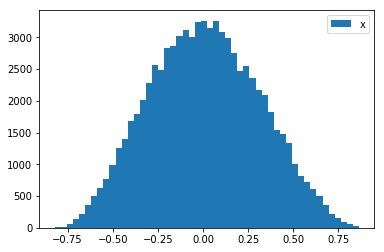

In [31]:
np.fill_diagonal(correlation_matrix2, None)
plt.pyplot.hist(correlation_matrix2.flatten(), bins=50, alpha=1, label='x')
plt.pyplot.legend(loc='upper right')
plt.pyplot.show()

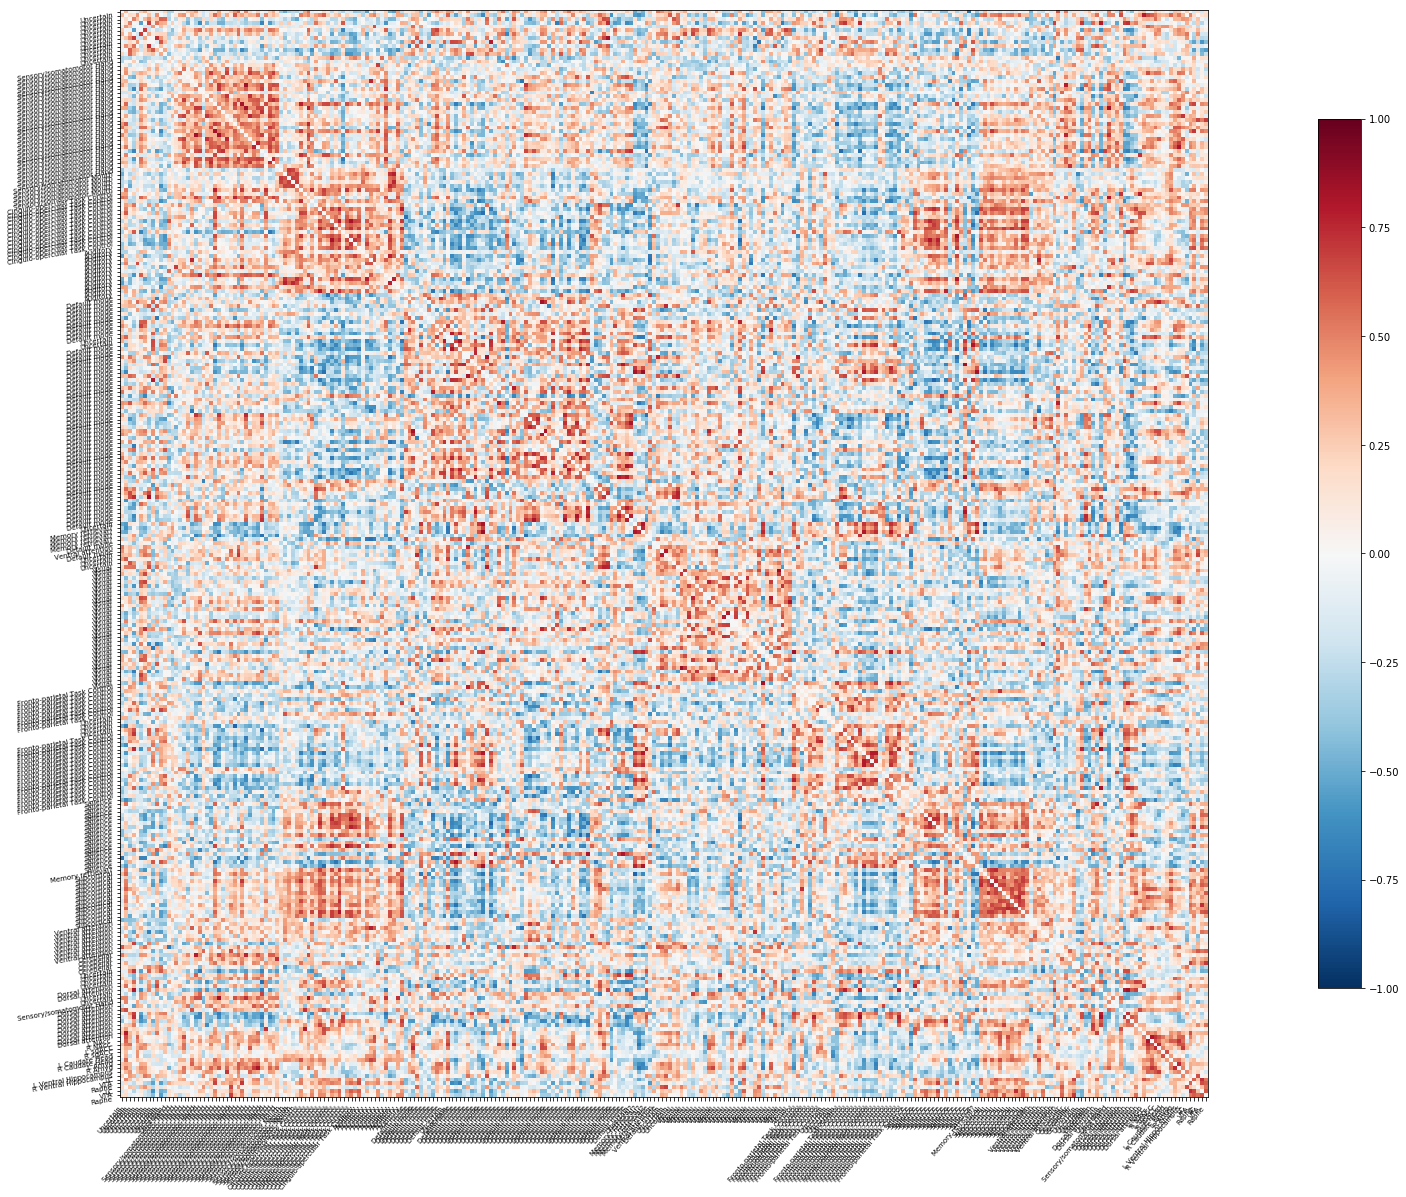

In [32]:
np.fill_diagonal(correlation_matrix2, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix2, figure=(25, 20), labels=power_drysdale_labels,
                     vmax=1, vmin=-1, reorder=False)

# Make a function to extract and write csv with rois and labels